# Importation et préparation de données

In [1]:
#Ici j'importe les librairies nécessaires pour importer les données les nettoyer et les analyser

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
tickets_data = pd.read_csv('/content/ticket_data.csv')
cities_data = pd.read_csv('/content/cities.csv')
stations_data = pd.read_csv('/content/stations.csv')
providers_data = pd.read_csv('/content/providers.csv')

In [3]:
# Ici j'ai renommé les colonnes des jeux de données grâce à Pandas afin de les rendre plus explicites et plus faciles à manipuler

tickets_data.rename(columns={'id':'ticket_id'}, inplace=True)

cities_data.drop(['local_name'], axis=1, inplace=True)
cities_data.rename(columns={'id':'city_id',
                            'unique_name':'city_name',
                            'latitude':'city_latitude',
                            'longitude':'city_longitude',
                            'population':'city_population'}, inplace=True)

stations_data.rename(columns={'id':'station_id',
                              'unique_name' : 'station_name',
                              'latitude':'station_latitude',
                              'longitude':'station_longitude'}, inplace=True)

providers_data.rename(columns={'id':'true_company_id',
                               'name':'company_name',
                               'fullname':'company_fullname'}, inplace=True)

In [4]:
# Ici j'utilise la classe SimpleImputer de scikit learn afin de remplacer les valeurs manquantes par les données les plus fréquentes 
# au niveau de chaque colonne des différents jeux de données

from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer(strategy='most_frequent')

tickets_data = pd.DataFrame(my_imputer.fit_transform(tickets_data), columns=tickets_data.columns)
cities_data = pd.DataFrame(my_imputer.fit_transform(cities_data), columns=cities_data.columns)
stations_data = pd.DataFrame(my_imputer.fit_transform(stations_data), columns=stations_data.columns)
providers_data = pd.DataFrame(my_imputer.fit_transform(providers_data), columns=providers_data.columns)

In [5]:
# Grâce à l'indication sur la page de l'exercice, j'ai compris la relation entre les différents fichiers csv et je les ai joint en un  seul jeu de données en me 
# basant sur ces relations

merged_tickets_cities = tickets_data.merge(cities_data, left_on='o_city', right_on='city_id').merge(cities_data, left_on='d_city', right_on='city_id')

merged_tickets_cities_companies = merged_tickets_cities.merge(providers_data, left_on='company', right_on='true_company_id')

full_data = merged_tickets_cities_companies.merge(stations_data, left_on='o_station', right_on='station_id').merge(stations_data, left_on='d_station', right_on='station_id')

In [6]:
# J'ai sélectionné ici les champs nécessaires pour analyser et comprendre les données afin d'en tirer des informations, une fois sélectionnée, j'ai renommé ces
# colonnes car leurs noms ont été modifié lors de l'opération des jointures

features = ['departure_ts', 'arrival_ts', 'search_ts', 'city_name_x', 'city_name_y', 'company_name', 
            'city_latitude_x', 'city_latitude_y', 'city_longitude_x', 'city_longitude_y',
            'has_wifi', 'has_plug', 'has_adjustable_seats', 'has_bicycle', 'transport_type',
            'station_name_x', 'station_name_y', 'station_latitude_x', 'station_latitude_y', 'station_longitude_x',
            'station_longitude_y', 'price_in_cents']
            
full_data_selected = full_data[features]
full_data_selected.columns = [col.replace('_x','') for col in full_data_selected.columns]
full_data_selected.rename(columns={'city_name':'departure_city',
                                   'city_name_y':'arrival_city',
                                   'station_name':'departure_station',
                                   'station_name_y':'arrival_station',
                                   'departure_ts' : 'departure_time',
                                   'arrival_ts' : 'arrival_time',
                                   'search_ts':'search_time',
                                   'city_latitude' : 'departure_city_latitude',
                                   'city_latitude_y' : 'arrival_city_latitude',
                                   'city_longitude' : 'departure_city_longitude',
                                   'city_longitude_y' : 'arrival_city_longitude',
                                   'station_latitude' : 'departure_station_latitude',
                                   'station_latitude_y' : 'arrival_station_latitude',
                                   'station_longitude' : 'departure_station_longitude',
                                   'station_longitude_y' : 'arrival_station_longitude',}, inplace=True)

In [7]:
# Ici, j'ai modifié les types de données dont notamment les dates, les données binaires et les données numériques afin de faciliter la manipulation et de créer
# d'autres colonnes nécessaires utiles pour la suite

for col in [col for col in full_data_selected.columns if 'time' in col] : 
  full_data_selected[col] = pd.to_datetime(full_data_selected[col])

for col in [col for col in full_data_selected.columns if 'has' in col] : 
  full_data_selected[col] = full_data_selected[col].astype('bool')

for col in [col for col in full_data_selected.columns if col.endswith('tude')]:
  full_data_selected[col] = full_data_selected[col].astype('float')

full_data_selected.price_in_cents = full_data_selected.price_in_cents.astype('int')

In [8]:
# J'ai ainsi créé ici une colonne "trip_duration_in_min" qui représente le temps de voyage en minutes entre les différentes villes

full_data_selected['trip_duration_in_min'] = (full_data_selected.arrival_time - full_data_selected.departure_time).apply(lambda x : int(pd.Timedelta(x).total_seconds()/60))

In [9]:
# Je me suis servi ici d'une librairie de python qui s'appelle geopy que j'ai utilisé pour calculer les distances entre les villes et les stations desservies 
# par TicTacTrip à partir des latitudes et des longitudes

from geopy import distance

def geopy_distance(lat1, lon1, lat2, lon2):
  
  p1 = (lat1, lon1)
  p2 = (lat2, lon2)

  return distance.distance(p1, p2).km

In [10]:
# la colonne de distance entre les villes est ici créée

full_data_selected['cities_distance_km'] = full_data_selected[['departure_city_latitude',
                                                            'departure_city_longitude',
                                                            'arrival_city_latitude',
                                                            'arrival_city_longitude']].apply(lambda x : geopy_distance(*x), axis=1)

In [11]:
# ici nous avons la distance entre les stations

full_data_selected['stations_distance_km'] = full_data_selected[['departure_station_latitude',
                                                            'departure_station_longitude',
                                                            'arrival_station_latitude',
                                                            'arrival_station_longitude']].apply(lambda x : geopy_distance(*x), axis=1)

In [12]:
# Ici, j'ai créé une colonne "trip" qui représente le trajet parcouru, ex : paris -> nantes

full_data_selected['trip'] = full_data_selected[['departure_city','arrival_city']].apply(lambda x : ' -> '.join([*x]), axis=1)

--------------------------------------------------------------------------------

In [13]:
# pour des questions de commodités, j'ai réarrangé l'ordre des colonnes et j'ai mis la colonne des prix à la fin 
# comme pour avoir un schéma de type x1, x2,...,xn, y

columns_rearranged = ['departure_time', 'arrival_time', 'search_time', 'departure_city',
       'arrival_city', 'trip', 'company_name', 'departure_city_latitude',
       'arrival_city_latitude', 'departure_city_longitude',
       'arrival_city_longitude', 'has_wifi', 'has_plug',
       'has_adjustable_seats', 'has_bicycle', 'transport_type',
       'departure_station', 'arrival_station', 'departure_station_latitude',
       'arrival_station_latitude', 'departure_station_longitude',
       'arrival_station_longitude', 'trip_duration_in_min',
       'cities_distance_km', 'stations_distance_km', 'price_in_cents']


final_data = full_data_selected.reindex(columns=columns_rearranged)

# Analyse de données

## Trajets et types de transport

##### Les 10 trajets les plus parcourus

In [14]:
# Ici j'ai extrait dans la variable "most_popular_trips" les trajets qui ont été les 10 trajets qui ont été les plus parcourus

most_popular_trips = pd.DataFrame(final_data.groupby('trip')['trip'].count()).rename(columns={'trip':'count'}).sort_values(by='count', ascending=False).head(10).reset_index()

*On retient ici que la plupart des voyages se font le plus souvent à partir de Paris*

##### Les 10 trajets les moins parcourus

In [15]:
# A l'opposé, j'ai extrait ici les 10 trajets qui ont été les moins parcourus

less_popular_trips = pd.DataFrame(final_data.groupby('trip')['trip'].count()).rename(columns={'trip':'count'}).sort_values(by='count', ascending=True).head(10).reset_index()

##### Les 10 trajets les plus chers

In [16]:
# Ici, nous avons les 10 trajets les plus coûteux

most_expensive_trips = pd.DataFrame(final_data.groupby('trip')['price_in_cents'].mean()).sort_values(by='price_in_cents', ascending=False).head(10).reset_index()

##### Les 10 trajets les moins chers

In [17]:
# Ici, les 10 trajets les moins coûteux

less_expensive_trips = pd.DataFrame(final_data.groupby('trip')['price_in_cents'].mean()).sort_values(by='price_in_cents', ascending=True).head(10).reset_index()

##### Les 10 trajets les plus longs

In [18]:
# Ici, nous avons les 10 trajets les plus longs en terme de distance

longest_trips = pd.DataFrame(final_data.groupby('trip')['cities_distance_km'].mean()).sort_values(by='cities_distance_km', ascending=False).head(10).reset_index()

##### Les 10 trajets les plus courts

In [19]:
# A l'opposé, ici nous avons les 10 trajets les plus courts

shortest_trips = pd.DataFrame(final_data.groupby('trip')['cities_distance_km'].mean()).sort_values(by='cities_distance_km', ascending=True).head(10).reset_index()

##### ---

In [20]:
# Dans la variable "min_duration_trip_transport_type_grouped", j'ai regroupé les trajets les plus courts par type de transport

min_duration_trip_transport_type_grouped = pd.DataFrame(final_data.groupby(['trip','transport_type','price_in_cents','company_name','cities_distance_km'])['trip_duration_in_min'].min()).reset_index()

### **Meilleures offres rapport distance-prix par trajets les plus parcourus, types de transport et compagnies**

In [21]:
# Grâce au regroupement précédemment fait, j'ai tiré les meilleurs prix proposés

popular_trip_ttype_min_duration = min_duration_trip_transport_type_grouped[min_duration_trip_transport_type_grouped['trip'].isin(list(most_popular_trips.trip))].sort_values(by=['trip_duration_in_min','price_in_cents'])

best_popular_trip_offers = pd.DataFrame(popular_trip_ttype_min_duration.groupby(['trip','transport_type','company_name','cities_distance_km'])['price_in_cents'].mean()).sort_values(by=['price_in_cents']).reset_index()

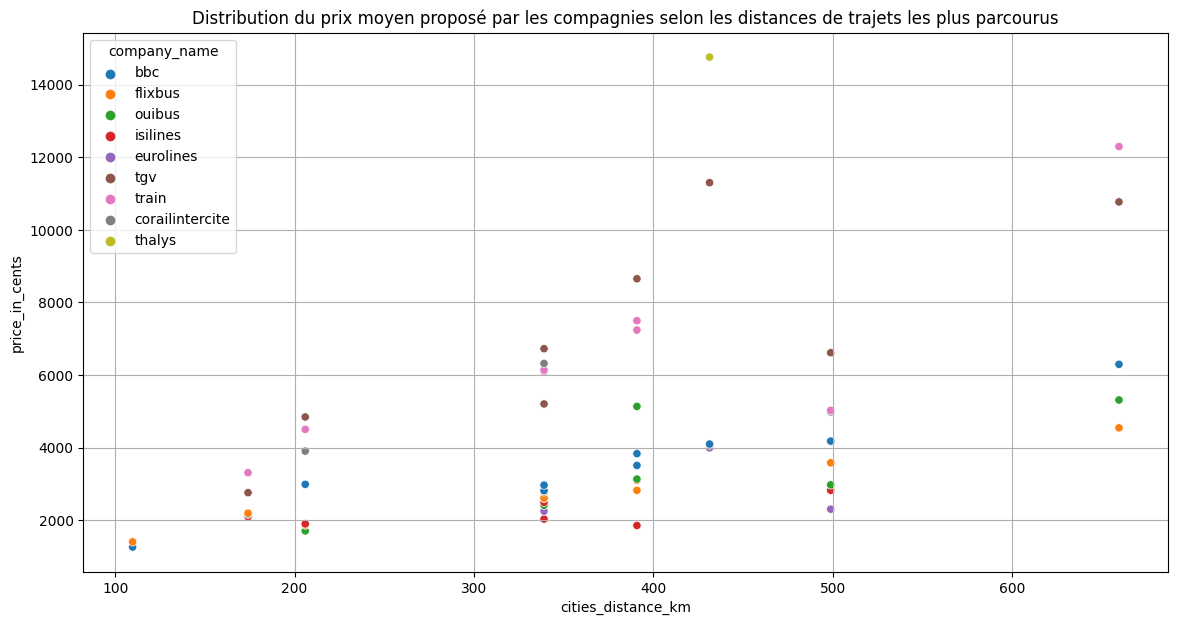

In [22]:
# La description de ce graphe se trouve juste en dessous

%matplotlib inline
plt.figure(figsize=(14,7));
sns.scatterplot(data=best_popular_trip_offers, x='cities_distance_km', y='price_in_cents', hue='company_name');
plt.title('Distribution du prix moyen proposé par les compagnies selon les distances de trajets les plus parcourus');
plt.grid()

***Ce graphe montre une corrélation avec une tendance linéaire entre la distance du trajet et le prix, et que les services telles que blablacar, isilines et flixbus font des offres relativement moins coûteux pour les trajets populaires***

### **Meilleures offres par trajets les moins parcourus, par type de transport, par prix et par compagnie**

In [23]:
# Grâce au même regroupement précédemment fait, j'ai tiré les meilleurs prix proposés pour les trajets les plus parcourus et pour les trajets les moins parcourus

popular_trip_ttype_min_duration = min_duration_trip_transport_type_grouped[min_duration_trip_transport_type_grouped['trip'].isin(list(less_popular_trips.trip))].sort_values(by=['trip_duration_in_min','price_in_cents'])

best_unpopular_trip_offers = pd.DataFrame(popular_trip_ttype_min_duration.groupby(['trip','transport_type','company_name','cities_distance_km'])['price_in_cents'].mean()).sort_values(by=['price_in_cents']).reset_index()

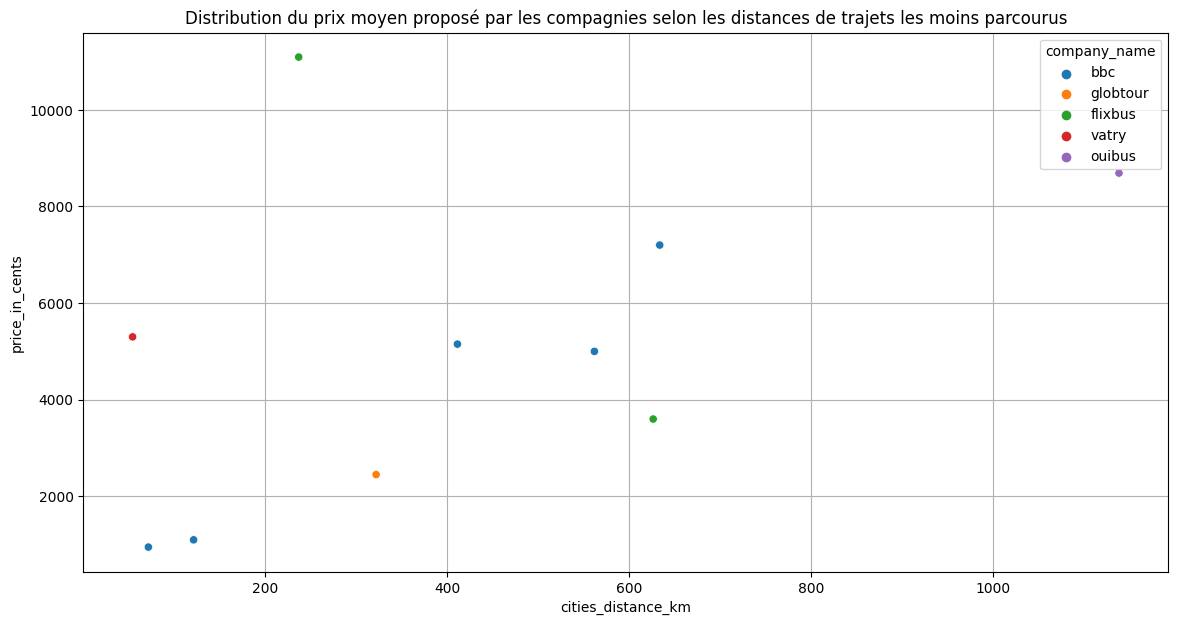

In [24]:
# La description du graphe se troue juste en dessous

%matplotlib inline
plt.figure(figsize=(14,7));
sns.scatterplot(data=best_unpopular_trip_offers, x='cities_distance_km', y='price_in_cents', hue='company_name');
plt.title('Distribution du prix moyen proposé par les compagnies selon les distances de trajets les moins parcourus');
plt.grid()

*Ce graphe montre que le covoiturage (blablacar) est le moyen le plus utilisé pour les trajets les moins parcourus*

### **Offres par trajets les plus chers, par type de transport, par prix et par compagnie**


In [25]:
# A l'opposé, j'ai tiré ici les prix les plus élevés pour les mêmes trajets

popular_trip_ttype_min_duration = min_duration_trip_transport_type_grouped[min_duration_trip_transport_type_grouped['trip'].isin(list(most_expensive_trips.trip))].sort_values(by=['trip_duration_in_min','price_in_cents'])

best_most_expensive_trip_offers = pd.DataFrame(popular_trip_ttype_min_duration.groupby(['trip','transport_type','company_name','cities_distance_km'])['price_in_cents'].mean()).sort_values(by=['price_in_cents']).reset_index()

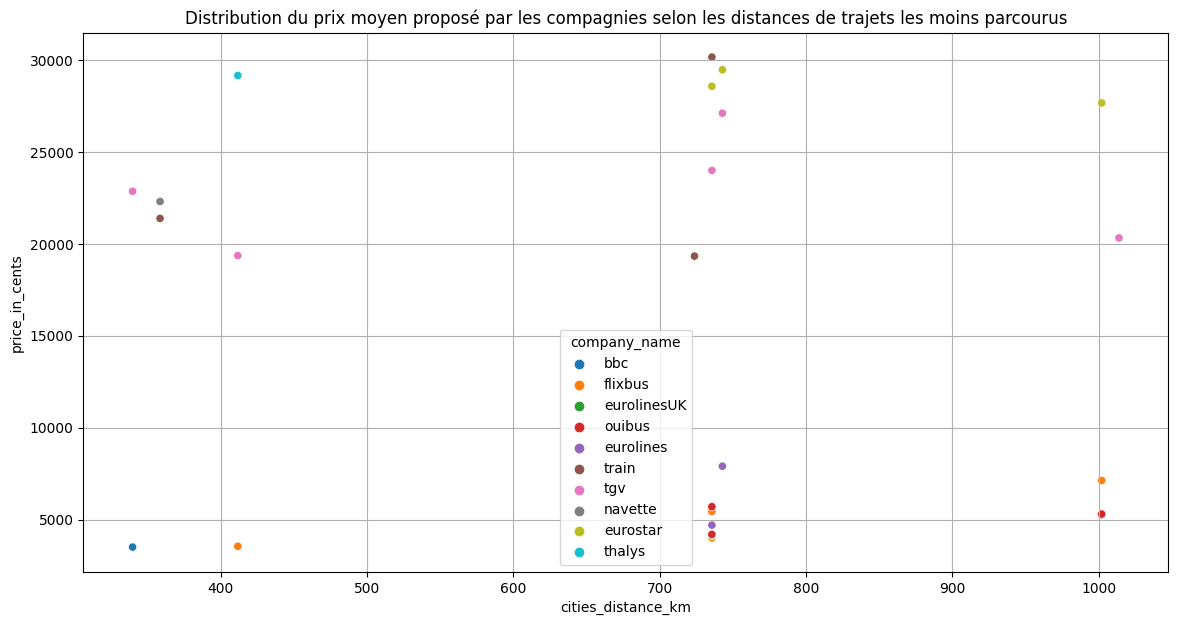

In [26]:
# Description juste en dessous du graphe

%matplotlib inline
plt.figure(figsize=(14,7));
sns.scatterplot(data=best_most_expensive_trip_offers, x='cities_distance_km', y='price_in_cents', hue='company_name');
plt.title('Distribution du prix moyen proposé par les compagnies selon les distances de trajets les moins parcourus');
plt.grid()

*Ce graphe montre que les voyages les plus coûteux sont pour la plupart effectués sur de longues distances (jusqu'à plus de 1000km) et desservis le plus par le train et le tgv avec des prix allant jusqu'à plus de 300 euros*

## Prix

#### Prix globaux

##### Prix minimal

In [27]:
# Ici, j'ai extrait le prix le plus bas proposé pour tous trajets et toutes distances confondues

trip_min_price = final_data.price_in_cents.min()
print(f'Prix minimal de voyage enregistré en minutes : {trip_min_price/100} euros')

Prix minimal de voyage enregistré en minutes : 3.0 euros


##### Type de transport qui a offert le prix le plus bas

In [28]:
# J'ai extrait ici un jeu de données qui comporte les types de transports et les compagnies qui ont donné ce prix le plus bas

less_price_transport_type_df = final_data[final_data.price_in_cents == trip_min_price][['price_in_cents','transport_type','company_name']]

<Figure size 1400x700 with 0 Axes>

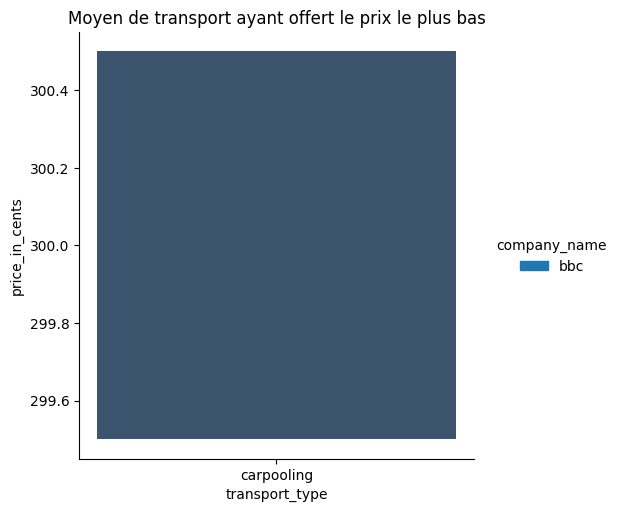

In [29]:
# Description juste en dessous de la figure

plt.figure(figsize=(14,7));
sns.displot(less_price_transport_type_df, x='transport_type', y='price_in_cents', hue='company_name')
plt.title('Moyen de transport ayant offert le prix le plus bas');

***Ce graphe montre que le covoiturage est le moyen qui propose le prix le plus bas (3 euros)***

##### Prix moyen global

In [30]:
# Ici, j'ai extrait le prix médian des trajets enregistrés

trip_median_price = final_data.price_in_cents.median()
print(f'Prix moyen de voyage enregistré en minutes : {trip_median_price/100} euros')

Prix moyen de voyage enregistré en minutes : 33.5 euros


In [31]:
# Jeu de données contenant les types de transport et compagnies qui ont proposé ce prix

median_price_transport_type_df = final_data[final_data.price_in_cents == trip_median_price][['price_in_cents','transport_type','company_name']]

<Figure size 1400x700 with 0 Axes>

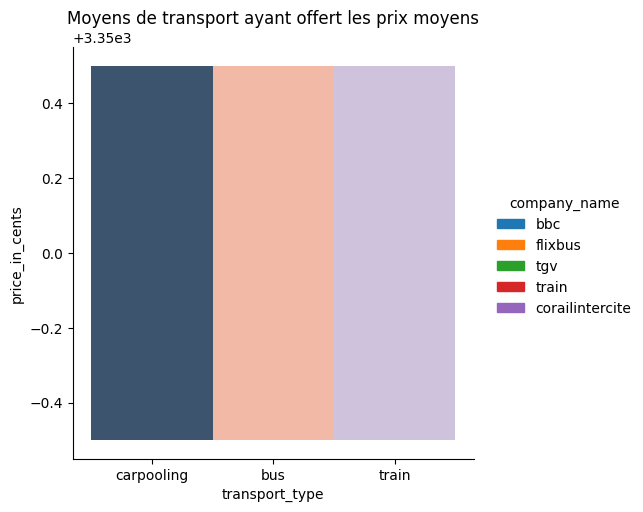

In [32]:
# Description juste en dessous de la figure

plt.figure(figsize=(14,7));
sns.displot(median_price_transport_type_df, x='transport_type', y='price_in_cents', hue='company_name');
plt.title('Moyens de transport ayant offert les prix moyens');

***Ce graphe montre que le prix moyen (33.5 euros) des trajets sont offerts par le covoiturage, le bus et le train et les compagnies dominantes sont "blablacar, flixbus, le tgv, le train et corailintercite"***

##### Prix maximal

In [33]:
# Prix le plus élevé tous trajets et tout type de transport confondus

trip_max_price = final_data.price_in_cents.max()
print(f'Prix moyen de voyage enregistré en minutes : {trip_max_price/100} euros')

Prix moyen de voyage enregistré en minutes : 385.5 euros


In [34]:
# Jeu de données contenant les types de transport et les compagnies ayant proposé ce prix élevé

max_price_transport_type_df = final_data[final_data.price_in_cents == trip_max_price][['price_in_cents','transport_type','company_name']]

<Figure size 1400x700 with 0 Axes>

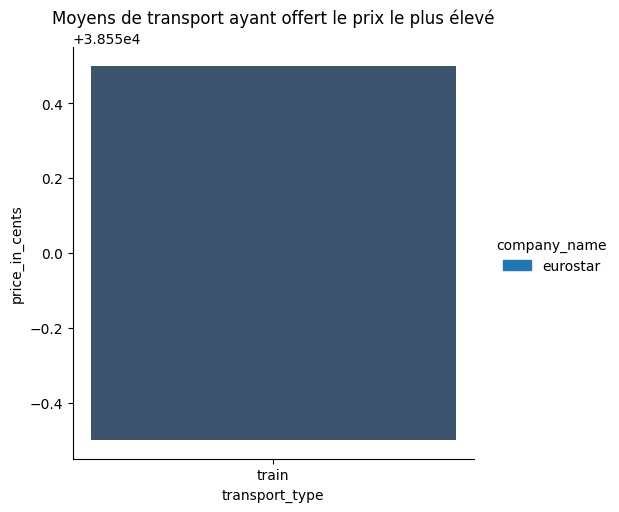

In [35]:
# Description juste en dessous de la figure

plt.figure(figsize=(14,7));
sns.displot(max_price_transport_type_df, x='transport_type', y='price_in_cents', hue='company_name');
plt.title('Moyens de transport ayant offert le prix le plus élevé');

***Ce graphe montre que le train est le moyen de transport qui propose le prix le plus élevé (386 euros) et la compagnie dominante est "eurostar"***

## ***Informations tirées de l'analyse des données***

* La plupart des voyages enregistrées se sont faites **à partir de Paris**
* Ces voyages sont faites sur des distances maximales d'environ 650 km via le **covoiturage, le bus et le train**. 
* La compagnie de covoiturage **Blablacar** et les bus **Isilines** et **Flixbus** offrent les **meilleurs prix** pour ces voyages (***moins de 20 euros pour une distance autour de 110 km et 61 euros pour une distance de plus 650 km***) tandis que l'offre **la plus chère** est proposée en **train** par la compagnie **thalys** (***plus de 140 euros pour une distance de moins de 450 km***)
* Pour un **trajet de plus de 1000km**, le prix le plus bas (***environ 51 euros***) est offert en **bus** par la compagnie de  **Ouibus** alors que pour cette même distance, le **tarif le plus cher (***environ 270 euros***)** est proposé en **train** par la compagnie Eurostar



# Prédictions

In [36]:
# Ici, j'ai utilisé le package scikit learn pour alimenter un modèle de forêt aléatoire avec les données

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [41]:
# Séparation des champs caractéristiques X et du champ à prédire y

X = final_data[['trip','company_name','has_wifi','has_plug','has_adjustable_seats',
                'has_bicycle','transport_type','trip_duration_in_min','cities_distance_km','stations_distance_km']]
y = final_data.price_in_cents

In [42]:
# Ici j'ai créé des pipelines pour mettre en forme les données afin qu'elles puissent être étudiées par le modèle

numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, ['trip_duration_in_min','cities_distance_km','stations_distance_km']),
        ('cat', categorical_transformer, ['trip','company_name','has_wifi','has_plug',
                                        'has_adjustable_seats','has_bicycle','transport_type'])
    ])

In [43]:
# Splittage du jeu de données afin d'évaluer la performance du modèle

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=0)

In [44]:
y_valid.shape

(14834,)

In [45]:
model = RandomForestRegressor(n_estimators=100, random_state=0)

In [ ]:
# Entraînement du modèle

from sklearn.metrics import mean_absolute_error

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

my_pipeline.fit(X_train, y_train)

In [47]:
# Prédiction et évaluation du modèle graĉe à la métrique de l'erreur moyenne absolue (score de 423,5)

preds = my_pipeline.predict(X_valid)

score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 423.5713652761852


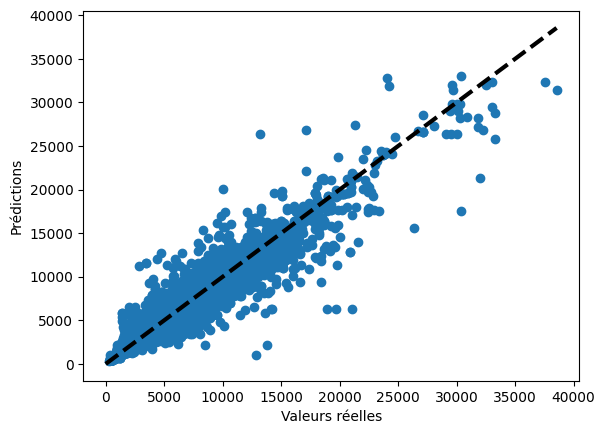

In [69]:
# Evaluation graphique du modèle, les coûts prédits par le modèle sont les points en bleu, less prix réels sont représentés par la ligne en pointillées noires

plt.scatter(y_valid, preds)
plt.plot([0, np.max(y_valid)], [0, np.max(y_valid)], 'k--', lw=3)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.show()

# Recherche et procédure suivie pour cet exercice

La démarche suivie pour réaliser cet exercice inclue les étapes suivantes:
* **Recherche d'informations sur Tictactrip, sa mission et son organisation:**
  
  J'ai compris que tictactrip est une société dont la mission est de comparer les prix des voyages terrestres à travers l'Europe. Elle aura donc besoin de connaître des informations sur les trajets, les coûts par type de transport, par compagnie afin de pouvoir proposer les meilleurs prix adaptés aux besoins des utilisateurs.

* **Visualisation des données:**

  J'ai regardé ce à quoi ressemblent les données afin d'avoir une idée de comment m'y prendre et les instructions qui suivent l'exercice m'ont permis de comprendre les relations entre les données.

* **Préparation des données:**
  
  La préparation des données s'est faite en renommant les colonnes du jeu de données, en remplaçant les valeurs nulles par les valeurs les plus fréquentes au niveau de chaque colonne, en ajoutant de nouvelles colonnes nécessaires pour l'analyse des données et l'extraction d'informations, puis en modifiant l'ordre des colonnes dans le jeu de données

* **Analyse des données:**

  J'ai extrait grâce à des requêtes pandas, des informations telles que les trajets les plus parcourus, les moins parcourus, les coûts en fonction des compagnies et des distances. J'ai représenté ces informations et les corrélations entre les champs sur des graphiques que j'ai décrit brièvement.

* **Construction d'un modèle de prédiction des prix:**

  J'ai construit ensuite un modèle de forêts aléatoires que j'ai entraîné grâce aux données et dont j'ai évalué la performance numériquement grâce à la métrique d'erreur moyenne absolue et graphiquement grâce à matplotlib




**NB:**
  J'ai chargé les données localement sur mon notebook pour cet exercice afin d'éviter de les rendre publiques; aucune indication n'ayant été donnée à ce sujet dans les instructions. 
  Ainsi pour exécuter ce notebook il faudra recharger les différents fichiers dans les variables associées que j'ai définies au tout début (*tickets_data, cities_data, providers_data et stations_data*)